# 07 Convolutional neural network

## Load data

### For both networks - the fully-connected and the convolutional one

Split the data into train, validation and test sets with respectively 3200, 800 and 1000 points.
Train the network using small random batches of data and monitor the validation accuracy.
Evaluate and print the test accuracy of the tuned model.

#### Using the high-level OverFeat features

Implement a convolutional neural network.
Plot the trained weights of the kernels from the first convolutional layer.

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
%matplotlib inline

In [7]:
# Load the data form the .npz
with np.load('cifar4-train.npz', allow_pickle=False) as npz_file:
    cifar4 = dict(npz_file.items())
# Overview of the data content     
print('Data keys {}'.format(cifar4.keys()))

Data keys dict_keys(['pixels', 'overfeat', 'labels', 'names', 'allow_pickle'])


In [8]:
# Convert pixels into floating point numbers
data = cifar4['pixels'].astype(np.float32)

# Rescale pixel values between -0.5 and 0.5
data = (data - 128) / 255

In [9]:
# Partition data set to be able to assess model performance and over/under fitting issues
# Create train set
X_train, X_test, y_train, y_test = train_test_split(
    # Reshape images (32 by 32)
    data.reshape(-1, 32, 32, 3), # RGB
    cifar4['labels'],
    test_size=1800, random_state=0
)

# Create validation and test sets
X_valid, X_test, y_valid, y_test = train_test_split(
    X_test, y_test, test_size=1000, random_state=0)

print('Train:', X_train.shape, y_train.shape)
print('Valid:', X_valid.shape, y_valid.shape)
print('Test:', X_test.shape, y_test.shape)

Train: (3200, 32, 32, 3) (3200,)
Valid: (800, 32, 32, 3) (800,)
Test: (1000, 32, 32, 3) (1000,)


In [10]:
# Create a batch generator to be able to send the training set by batch,
# and in a random manner between each epoch

# Batch generator
def get_batches(X, y, batch_size):
    # Shuffle X,y
    shuffled_idx = np.arange(len(y)) # 1,2,...,n
    np.random.shuffle(shuffled_idx)
    
    # Enumerate indexes by steps of batch_size
    # i: 0, b, 2b, 3b, 4b, .. where b is the batch size
    for i in range(0, len(y), batch_size):
        # Batch indexes
        batch_idx = shuffled_idx[i:i+batch_size]
        yield X[batch_idx], y[batch_idx]

## Create a ConvNet architecture (graph)

In [11]:
# Create new graph
graph = tf.Graph()

with graph.as_default():
    # Placeholders
    X = tf.placeholder(dtype=tf.float32, shape=[None, 32, 32, 3])
    y = tf.placeholder(dtype=tf.int32, shape=[None])
    print ('input:', X.shape)
    
    # Convolutional layer 1
    conv1 = tf.layers.conv2d(
        X, # Input data
        filters=64, # 64 filters
        kernel_size=(5, 5), # Kernel size: 5x5
        strides=(2, 2), # Stride: 2
        padding='SAME', # "same" padding
        activation=tf.nn.relu, # ReLU
        kernel_initializer=tf.truncated_normal_initializer(
            stddev=0.01, seed=0), # Small standard deviation
        name='conv1' # Add name
    )
    print('Convolutional layer 1:', conv1.shape)
    
    # Max pooling layer 1
    pool1 = tf.layers.max_pooling2d(
        conv1, # Convolution output
        pool_size=(2, 2), # Pool size: 2
        strides=(2, 2), # Stride: 2
        padding='SAME' # "same" padding
    )
    print('Maxpool 1:', pool1.shape)
    
    # Convolutional layer 2
    conv2 = tf.layers.conv2d(
        pool1, # Max pooling output
        filters=64, # 64 filters
        kernel_size=(3, 3), # Kernel size: 3x3
        strides=(1, 1), # Stride: 1
        padding='SAME', # "same" padding
        activation=tf.nn.relu, # ReLU
        kernel_initializer=tf.truncated_normal_initializer(
            stddev=0.01, seed=0), # Small standard deviation
        name='conv2' # Add name
    )
    print('Convolutional layer 2:', conv2.shape)

    # Max pooling layer 2 (2x2, stride: 2)
    pool2 = tf.layers.max_pooling2d(
        conv2, pool_size=(2, 2), strides=(2, 2), padding='SAME')
    print('Maxpool 2:', pool2.shape)
    
    # Flatten output
    flat_output = tf.contrib.layers.flatten(pool2)
    print('Flatten:',flat_output.shape)
    
    # Apply dropout
    training = tf.placeholder(dtype=tf.bool) # Create training placeholder
    flat_output = tf.layers.dropout(
        flat_output, rate=0.5, seed=0, training=training)
    print('Dropout:', flat_output.shape)
    
    # Fully connected layer
    fc1 = tf.layers.dense(
        flat_output, 256, # 256 hidden units
        activation=tf.nn.relu, # ReLU
        kernel_initializer=tf.variance_scaling_initializer(scale=2, seed=0),
        bias_initializer=tf.zeros_initializer()
    )
    print('Fully-connected layer:', fc1.shape)
    
    # Output layer
    logits = tf.layers.dense(
        fc1, 10, # Output units: 10, One output unit per category
        activation=None, # No activation function
        kernel_initializer=tf.variance_scaling_initializer(scale=1, seed=0),
        bias_initializer=tf.zeros_initializer()
    )
    print('Output layer:', logits.shape)
    
     # Kernel of the 1st conv. layer
    with tf.variable_scope('conv1', reuse=True):
        conv_kernels = tf.get_variable('kernel')

    # Mean cross-entropy
    mean_ce = tf.reduce_mean(
        tf.nn.sparse_softmax_cross_entropy_with_logits(
            labels=y, logits=logits))

    # Adam optimizer
    lr = tf.placeholder(dtype=tf.float32)
    gd = tf.train.AdamOptimizer(learning_rate=lr)
    
    # L2 term
    l2_term = tf.nn.l2_loss(conv_kernels)
    # Regularization strength
    alpha = tf.placeholder(dtype=tf.float32)
    # Loss function
    loss = mean_ce + alpha * l2_term

    # Training operation
    train_op = gd.minimize(loss)

    # Compute predictions and accuracy
    predictions = tf.argmax(logits, axis=1, output_type=tf.int32)
    is_correct = tf.equal(y, predictions)
    accuracy = tf.reduce_mean(tf.cast(is_correct, dtype=tf.float32))

input: (?, 32, 32, 3)
Convolutional layer 1: (?, 16, 16, 64)
Maxpool 1: (?, 8, 8, 64)
Convolutional layer 2: (?, 8, 8, 64)
Maxpool 2: (?, 4, 4, 64)
Flatten: (?, 1024)
Dropout: (?, 1024)
Fully-connected layer: (?, 256)
Output layer: (?, 10)


In [12]:
with graph.as_default():
    # Get variables in the graph
    for v in tf.trainable_variables():
        print(v)

<tf.Variable 'conv1/kernel:0' shape=(5, 5, 3, 64) dtype=float32_ref>
<tf.Variable 'conv1/bias:0' shape=(64,) dtype=float32_ref>
<tf.Variable 'conv2/kernel:0' shape=(3, 3, 64, 64) dtype=float32_ref>
<tf.Variable 'conv2/bias:0' shape=(64,) dtype=float32_ref>
<tf.Variable 'dense/kernel:0' shape=(1024, 256) dtype=float32_ref>
<tf.Variable 'dense/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'dense_1/kernel:0' shape=(256, 10) dtype=float32_ref>
<tf.Variable 'dense_1/bias:0' shape=(10,) dtype=float32_ref>


## Train the ConvNet

In [15]:
# Validation accuracy

# Train and validation accuracy after each epoch
valid_acc_values = []
train_acc_values = []

with tf.Session(graph=graph) as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())

    # Set seed
    np.random.seed(0)

    # Train several epochs
    for epoch in range(60):
        # Accuracy values (train) after each batch
        batch_acc = []

        # Get batches of data
        for X_batch, y_batch in get_batches(X_train, y_train, 200):
            # Run training and evaluate accuracy
            _, acc_value = sess.run([train_op, accuracy], feed_dict={
                X: X_batch,
                y: y_batch,
                lr: 0.001, # Learning rate
                training: True, # Apply dropout
                alpha: 0.8 # Regularization strength
            })

            # Save accuracy (current batch)
            batch_acc.append(acc_value)

        # Evaluate validation accuracy
        valid_acc = sess.run(accuracy, feed_dict={
            X: X_valid,
            y: y_valid,
            training: False # Do not apply dropout
        })
        valid_acc_values.append(valid_acc)
        # Also save train accuracy (we will use the mean batch score)
        train_acc_values.append(np.mean(batch_acc))

        # Print progress
        print('Epoch {} - valid: {:.3f} train: {:.3f} (mean)'.format(
            epoch+1, valid_acc, np.mean(batch_acc)
        ))

    # Get 1st conv. layer kernels
    kernels = conv_kernels.eval()
    
    # Evaluate test accuracy
    test_acc = sess.run(accuracy, feed_dict={
        X: X_test,
        y: y_test, 
            training: False
    })
    print('Convolutional network test accuracy: {:.3f}'.format(test_acc))

Epoch 1 - valid: 0.349 train: 0.270 (mean)
Epoch 2 - valid: 0.442 train: 0.418 (mean)
Epoch 3 - valid: 0.510 train: 0.471 (mean)
Epoch 4 - valid: 0.500 train: 0.488 (mean)
Epoch 5 - valid: 0.517 train: 0.492 (mean)
Epoch 6 - valid: 0.520 train: 0.520 (mean)
Epoch 7 - valid: 0.531 train: 0.525 (mean)
Epoch 8 - valid: 0.554 train: 0.530 (mean)
Epoch 9 - valid: 0.558 train: 0.541 (mean)
Epoch 10 - valid: 0.560 train: 0.544 (mean)
Epoch 11 - valid: 0.570 train: 0.555 (mean)
Epoch 12 - valid: 0.574 train: 0.570 (mean)
Epoch 13 - valid: 0.577 train: 0.551 (mean)
Epoch 14 - valid: 0.587 train: 0.573 (mean)
Epoch 15 - valid: 0.572 train: 0.575 (mean)
Epoch 16 - valid: 0.594 train: 0.582 (mean)
Epoch 17 - valid: 0.620 train: 0.588 (mean)
Epoch 18 - valid: 0.613 train: 0.601 (mean)
Epoch 19 - valid: 0.594 train: 0.598 (mean)
Epoch 20 - valid: 0.625 train: 0.611 (mean)
Epoch 21 - valid: 0.624 train: 0.595 (mean)
Epoch 22 - valid: 0.642 train: 0.617 (mean)
Epoch 23 - valid: 0.635 train: 0.627 (mea

## Display assessment curves

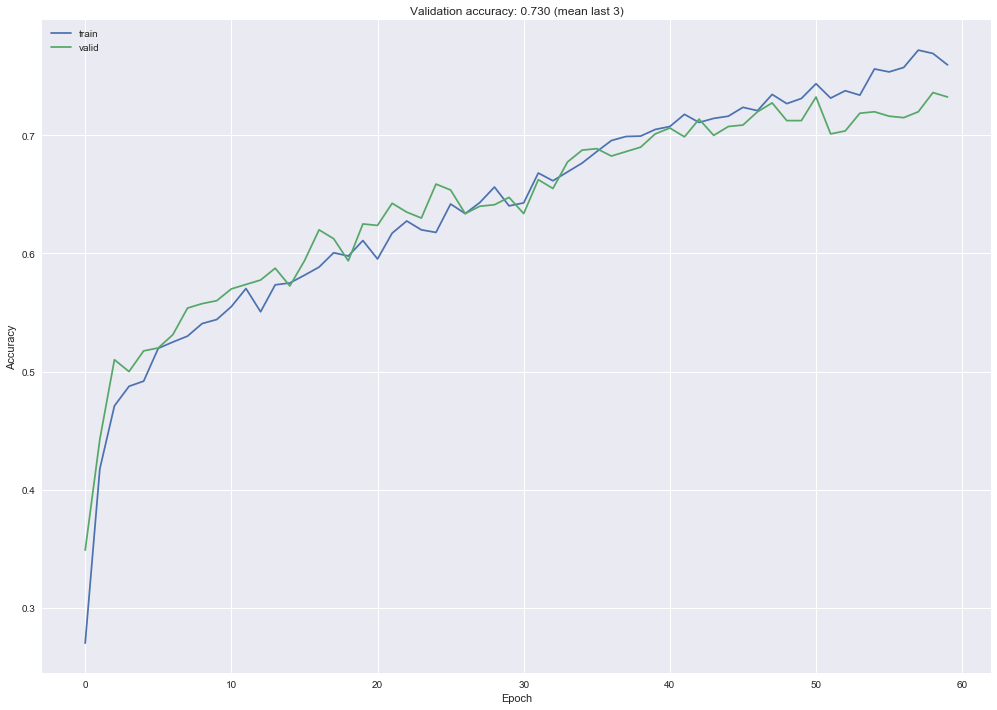

In [14]:
# Plot accuracy values
fig = plt.figure(figsize=(17, 12))
sns.set()
# Plot training curves
plt.plot(train_acc_values, label='train')
plt.plot(valid_acc_values, label='valid')
plt.title('Validation accuracy: {:.3f} (mean last 3)'.format(
    np.mean(valid_acc_values[-3:]) # last three values
))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Visualize kernels

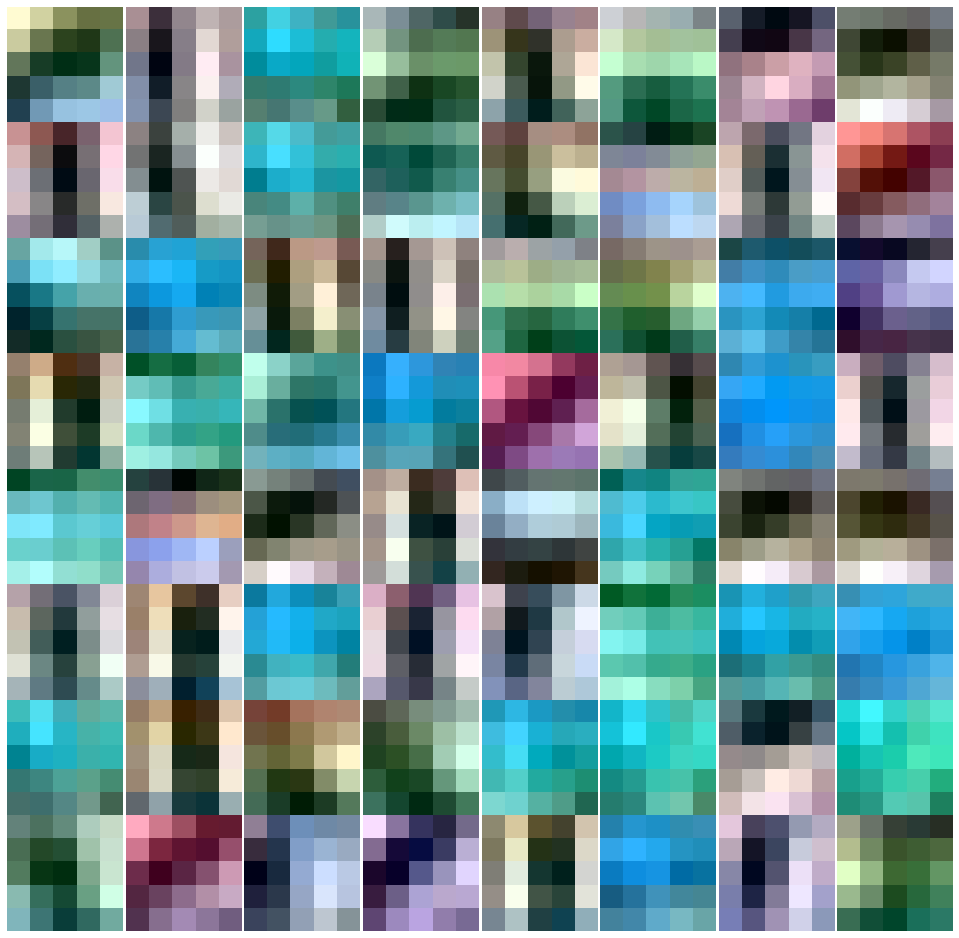

In [10]:
# Create a grid of subplots
fig, axes = plt.subplots(nrows=8, ncols=8, figsize=(17, 17))

# Remove gaps between suplots
plt.subplots_adjust(wspace=0, hspace=0)

# Plot the 64 kernels from the first convolutional layer
for i, axis in enumerate(axes.flatten()):
    # Get i-th kernel (shape: 5x5x3)
    kernel = kernels[:, :, :, i].copy()
    
    # Rescale values between 0 and 1
    kernel -= kernel.min() # Rescale between 0 and max
    kernel /= kernel.max() # Rescale between 0 and 1
    
    # Plot kernel with imshow()
    axis.imshow(kernel)
    axis.get_xaxis().set_visible(False) # disable x-axis
    axis.get_yaxis().set_visible(False) # disable y-axis
    
plt.show()